# <font color=blue>E-Commerce B2B case study</font>

In [935]:
#import the warnings.
import warnings
warnings.filterwarnings("ignore")

In [936]:
#import the useful libraries.
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

### <font color=blue>1. Data Prepartion</font>

### Read in the historical dataset

In [937]:
#read the data set of "application_data" in inp0.
inp0= pd.read_csv("Received_Payments_Data.csv")

In [938]:
# checking the shape of the dataset
inp0.shape

(93937, 16)

In [939]:
inp0.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


In [940]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

### Data cleaning and manipulation

In [941]:
inp0.isnull().sum()

RECEIPT_METHOD            0
CUSTOMER_NAME             0
CUSTOMER_NUMBER           0
RECEIPT_DOC_NO           29
RECEIPT_DATE              0
CLASS                     0
CURRENCY_CODE             0
Local Amount              0
USD Amount                0
INVOICE_ALLOCATED         0
INVOICE_CREATION_DATE     0
DUE_DATE                  0
PAYMENT_TERM              0
INVOICE_CLASS             0
INVOICE_CURRENCY_CODE     0
INVOICE_TYPE              0
dtype: int64

##### <font color=green>Only one variable has null data. This variable can be dropped as it is not relevant for modeling</font> 

In [942]:
inp0['CUSTOMER_NAME'].nunique()

690

In [943]:
inp0['CUSTOMER_NUMBER'].nunique()

1054

##### <font color=green>Many customers are allocated multiple customer numbers</font>

In [944]:
# converting customer number to String
inp0["CUSTOMER_NUMBER"] = inp0["CUSTOMER_NUMBER"].astype(str)

#### Checking the categorical variables

In [945]:
inp0['CLASS'].value_counts()

PMT    93937
Name: CLASS, dtype: int64

In [946]:
inp0['INVOICE_CLASS'].value_counts()

INV    88124
CM      5261
DM       552
Name: INVOICE_CLASS, dtype: int64

In [947]:
inp0['INVOICE_TYPE'].value_counts()

Goods        66715
Non Goods    27222
Name: INVOICE_TYPE, dtype: int64

In [948]:
inp0['RECEIPT_METHOD'].value_counts()

WIRE             84407
AP/AR Netting     4847
CHEQUE            3472
CASH               782
I/C WIRE           211
PDC                210
I/C Check            6
I/C CASH             2
Name: RECEIPT_METHOD, dtype: int64

In [949]:
inp0['INVOICE_CURRENCY_CODE'].value_counts()

SAR    39199
AED    32377
USD    18547
EUR     1519
KWD     1089
QAR      611
BHD      400
GBP      134
JOD       38
ZAR       23
Name: INVOICE_CURRENCY_CODE, dtype: int64

In [950]:
## Removing ZAR currency code from the train data as it is missing in the real data

In [951]:
indexCurr = inp0[inp0['INVOICE_CURRENCY_CODE'] == 'ZAR'].index


In [952]:
inp0.drop(indexCurr , inplace=True)

#### Correcting the datatypes

In [953]:
inp0['INVOICE_CREATION_DATE'] = pd.to_datetime(inp0['INVOICE_CREATION_DATE'])

In [954]:
inp0['RECEIPT_DATE'] = pd.to_datetime(inp0['RECEIPT_DATE'])

In [955]:
inp0['DUE_DATE'] = pd.to_datetime(inp0['DUE_DATE'])

#### Recreating Payment Term variable based on Due data and Invoice creation date

In [956]:
inp0['PAYMENT_TERM'] = inp0['DUE_DATE'] - inp0['INVOICE_CREATION_DATE']

In [957]:
inp0['PAYMENT_TERM'] =inp0['PAYMENT_TERM'].dt.days

In [958]:
inp0.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,58,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30,INV,SAR,Non Goods


In [959]:
#Check how many Payment term entries are negative
inp0[inp0['PAYMENT_TERM']<0]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
148,WIRE,RADW Corp,34647,1.000000e+11,2021-04-14,PMT,USD,2345.81,2345.810000,1.0021E+11,2021-04-01,2021-03-31,-1,INV,AED,Non Goods
152,WIRE,RADW Corp,34647,1.000000e+11,2021-04-14,PMT,USD,2345.81,2345.810000,1.0021E+11,2021-04-01,2021-03-31,-1,INV,AED,Non Goods
160,WIRE,REAL Corp,4002,1.000000e+11,2021-04-20,PMT,AED,98247.31,98247.310000,PAY1001522100494,2021-03-31,2021-03-01,-30,INV,AED,Non Goods
161,WIRE,REAL Corp,4002,1.000000e+11,2021-04-20,PMT,AED,98247.31,98247.310000,PAY1001522100496,2021-03-31,2021-03-01,-30,CM,AED,Non Goods
167,WIRE,RADW Corp,34647,1.000000e+11,2021-04-24,PMT,AED,10861.54,10861.540000,1.0021E+11,2021-04-01,2021-03-31,-1,INV,AED,Non Goods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93881,WIRE,SAUD Corp,38035,2.910000e+11,2021-05-31,PMT,SAR,0.00,0.000000,2000006765,2020-06-28,2017-09-06,-1026,INV,SAR,Non Goods
93882,WIRE,SAUD Corp,38035,2.910000e+11,2021-05-31,PMT,SAR,0.00,0.000000,2000006917,2020-06-28,2017-09-09,-1023,INV,SAR,Non Goods
93883,WIRE,SAUD Corp,38035,2.910000e+11,2021-05-31,PMT,SAR,0.00,0.000000,2000007075,2020-06-28,2017-09-13,-1019,INV,SAR,Non Goods
93903,WIRE,SCOP Corp,50801,2.970000e+11,2021-06-07,PMT,AED,23875.00,6501.021103,2.9721E+11,2021-03-04,2021-03-01,-3,INV,AED,Non Goods


In [960]:
inp0['PAYMENT_TERM'].describe()

count    93914.000000
mean        42.254350
std         61.357531
min      -3622.000000
25%         30.000000
50%         45.000000
75%         60.000000
max        365.000000
Name: PAYMENT_TERM, dtype: float64

##### Reseting the payment terms for all rows to 0, where payment term is negative (as due date cannot be post invoice generation)

In [961]:
inp0['PAYMENT_TERM'] = np.where(inp0['PAYMENT_TERM']<0, 0, inp0['PAYMENT_TERM'])

In [962]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93914 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         93914 non-null  object        
 1   CUSTOMER_NAME          93914 non-null  object        
 2   CUSTOMER_NUMBER        93914 non-null  object        
 3   RECEIPT_DOC_NO         93885 non-null  float64       
 4   RECEIPT_DATE           93914 non-null  datetime64[ns]
 5   CLASS                  93914 non-null  object        
 6   CURRENCY_CODE          93914 non-null  object        
 7   Local Amount           93914 non-null  float64       
 8   USD Amount             93914 non-null  float64       
 9   INVOICE_ALLOCATED      93914 non-null  object        
 10  INVOICE_CREATION_DATE  93914 non-null  datetime64[ns]
 11  DUE_DATE               93914 non-null  datetime64[ns]
 12  PAYMENT_TERM           93914 non-null  int64         
 13  I

##### Dropping rows that have zero or less in invoice amount

In [963]:
inp0[inp0['USD Amount']<=0].size

18016

In [964]:
inp0=inp0[inp0['USD Amount']>0]

In [965]:
inp0.shape

(92788, 16)

In [966]:
inp0.shape

(92788, 16)

In [967]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92788 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         92788 non-null  object        
 1   CUSTOMER_NAME          92788 non-null  object        
 2   CUSTOMER_NUMBER        92788 non-null  object        
 3   RECEIPT_DOC_NO         92759 non-null  float64       
 4   RECEIPT_DATE           92788 non-null  datetime64[ns]
 5   CLASS                  92788 non-null  object        
 6   CURRENCY_CODE          92788 non-null  object        
 7   Local Amount           92788 non-null  float64       
 8   USD Amount             92788 non-null  float64       
 9   INVOICE_ALLOCATED      92788 non-null  object        
 10  INVOICE_CREATION_DATE  92788 non-null  datetime64[ns]
 11  DUE_DATE               92788 non-null  datetime64[ns]
 12  PAYMENT_TERM           92788 non-null  int64         
 13  I

In [968]:
inp0.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,58,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30,INV,SAR,Non Goods


##### Add an Age column for data analysis (days taken to pay post invoice creation)

In [969]:
inp0['AGE'] = inp0['RECEIPT_DATE'] - inp0['INVOICE_CREATION_DATE']

In [970]:
inp0['AGE'] = inp0['AGE'].dt.days

##### Reseting the AGE <0 to 0 

In [971]:
inp0[inp0['AGE']<0]

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,AGE
56,WIRE,QATA Corp,2273,1.000000e+11,2021-01-19,PMT,AED,38302.39,38302.390000,1.0021E+11,2021-01-28,2021-01-28,0,CM,USD,Non Goods,-9
211,WIRE,QATA Corp,2273,1.000000e+11,2021-06-22,PMT,AED,66940.58,66940.580000,1.0021E+11,2021-06-24,2021-06-22,0,CM,USD,Non Goods,-2
281,CHEQUE,MALI Corp,42223,1.010000e+11,2021-01-05,PMT,SAR,111918.00,29838.837940,1.0121E+11,2021-01-12,2021-02-15,34,INV,SAR,Goods,-7
286,WIRE,MANF Corp,48601,1.010000e+11,2021-01-05,PMT,SAR,50000.00,13330.669750,1.0121E+11,2021-01-09,2021-01-09,0,INV,SAR,Goods,-4
288,WIRE,MANF Corp,48601,1.010000e+11,2021-01-06,PMT,SAR,50000.00,13330.669750,1.0121E+11,2021-01-09,2021-01-09,0,INV,SAR,Goods,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91522,WIRE,NOON Corp,38297,2.820000e+11,2021-05-24,PMT,AED,9343.36,2544.141593,2.8221E+11,2021-06-15,2021-08-30,76,INV,AED,Goods,-22
91523,WIRE,NOON Corp,38297,2.820000e+11,2021-05-24,PMT,AED,9343.36,2544.141593,2.8221E+11,2021-06-20,2021-08-30,71,INV,AED,Goods,-27
91524,WIRE,NOON Corp,38297,2.820000e+11,2021-05-24,PMT,AED,9343.36,2544.141593,2.8221E+11,2021-06-15,2021-08-30,76,INV,AED,Goods,-22
91525,WIRE,NOON Corp,38297,2.820000e+11,2021-05-24,PMT,AED,9533.40,2595.888359,2.8221E+11,2021-06-15,2021-08-30,76,INV,AED,Goods,-22


In [972]:
inp0['AGE'] = np.where(inp0['AGE']<0, 0, inp0['AGE'])

 #### Create Target variable ('1' indicates late payments and '0' indicates ontime payments)

In [973]:
inp0['TARGET'] = np.where(inp0['RECEIPT_DATE']>inp0['DUE_DATE'], 1,0 )

In [974]:
inp0.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,AGE,TARGET
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,58,INV,AED,Non Goods,169,1
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30,INV,SAR,Non Goods,33,1
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30,INV,SAR,Non Goods,1,0
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30,INV,SAR,Non Goods,47,1
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30,INV,SAR,Non Goods,47,1


In [975]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92788 entries, 0 to 93936
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         92788 non-null  object        
 1   CUSTOMER_NAME          92788 non-null  object        
 2   CUSTOMER_NUMBER        92788 non-null  object        
 3   RECEIPT_DOC_NO         92759 non-null  float64       
 4   RECEIPT_DATE           92788 non-null  datetime64[ns]
 5   CLASS                  92788 non-null  object        
 6   CURRENCY_CODE          92788 non-null  object        
 7   Local Amount           92788 non-null  float64       
 8   USD Amount             92788 non-null  float64       
 9   INVOICE_ALLOCATED      92788 non-null  object        
 10  INVOICE_CREATION_DATE  92788 non-null  datetime64[ns]
 11  DUE_DATE               92788 non-null  datetime64[ns]
 12  PAYMENT_TERM           92788 non-null  int64         
 13  I

### <font color=blue>2. Data Analysis</font>

In [976]:
inp0.describe()

,RECEIPT_DOC_NO,Local Amount,USD Amount,PAYMENT_TERM,AGE,TARGET
count,9.275900e+04,9.278800e+04,9.278800e+04,92788.000000,92788.000000,92788.000000
mean,1.581998e+11,1.079641e+06,5.377440e+05,45.841542,111.161045,0.656443
std,3.829402e+10,1.551885e+06,9.549053e+05,27.166422,187.513393,0.474898
min,1.421000e+10,4.830000e+00,1.287743e+00,0.000000,0.000000,0.000000
25%,1.470000e+11,9.055659e+04,4.034563e+04,30.000000,39.000000,0.000000
50%,1.510000e+11,4.160992e+05,1.915275e+05,45.000000,64.000000,1.000000
75%,1.690000e+11,1.465108e+06,5.996137e+05,60.000000,89.000000,1.000000
max,2.970000e+11,1.084983e+07,1.084983e+07,365.000000,2315.000000,1.000000


In [977]:
inp0['USD Amount'].describe()

count    9.278800e+04
mean     5.377440e+05
std      9.549053e+05
min      1.287743e+00
25%      4.034563e+04
50%      1.915275e+05
75%      5.996137e+05
max      1.084983e+07
Name: USD Amount, dtype: float64

#### Analyzing columns USD Amount

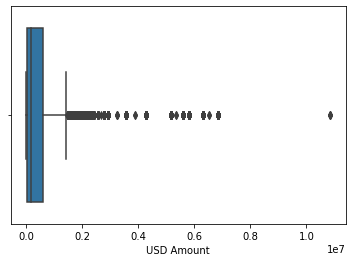

In [978]:
sns.boxplot(inp0['USD Amount'])
plt.show()

##### Median of the trasaction amount is 20,000 USD. There are few outliers with large amounts

In [979]:
inp0.INVOICE_TYPE.value_counts(normalize=True)

Goods        0.717183
Non Goods    0.282817
Name: INVOICE_TYPE, dtype: float64

In [980]:
inp0.PAYMENT_TERM.describe()

count    92788.000000
mean        45.841542
std         27.166422
min          0.000000
25%         30.000000
50%         45.000000
75%         60.000000
max        365.000000
Name: PAYMENT_TERM, dtype: float64

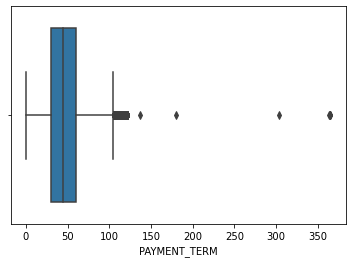

In [981]:
sns.boxplot(inp0['PAYMENT_TERM'])
plt.show()

##### 75% of the payment terms are less than 60 days

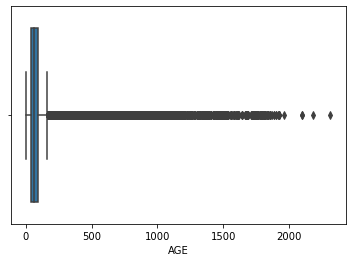

In [982]:
sns.boxplot(inp0['AGE'])
plt.show()

In [983]:
inp0['AGE'].describe()

count    92788.000000
mean       111.161045
std        187.513393
min          0.000000
25%         39.000000
50%         64.000000
75%         89.000000
max       2315.000000
Name: AGE, dtype: float64

In [984]:
inp0.TARGET.value_counts(normalize=True)

1    0.656443
0    0.343557
Name: TARGET, dtype: float64

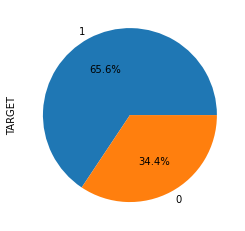

In [985]:
inp0.TARGET.value_counts(normalize= True).plot.pie(autopct='%1.1f%%')
plt.show()

##### 65.6% of the transaction end up in late payments, while 34.4% make ontime payments

In [986]:
def univariate_box(df,col):
    plt.figure(figsize=(8,6)) 
    sns.boxplot(data=df, x=col)
    plt.title('Box Plot of {}'.format(col))

In [987]:
def univariate_count(df,col):
    plt.figure(figsize=(8,6)) 
    sns.countplot(data=df, x=col)
    plt.title('Bar Plot of {}'.format(col))

##### Above graph shows Cash loans thare much more than Revolving loans

In [988]:
inp0['RECEIPT_METHOD'].value_counts(normalize=True)

WIRE             0.897293
AP/AR Netting    0.052237
CHEQUE           0.037419
CASH             0.008428
I/C WIRE         0.002274
PDC              0.002263
I/C Check        0.000065
I/C CASH         0.000022
Name: RECEIPT_METHOD, dtype: float64

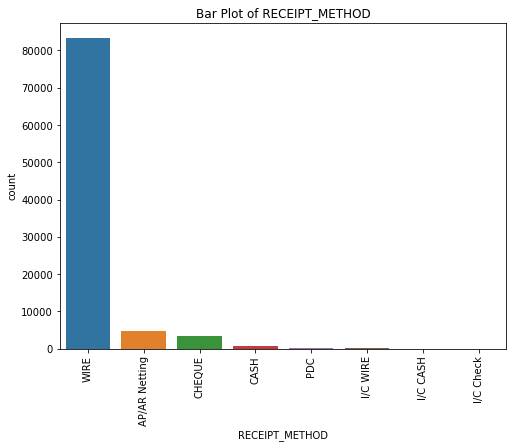

In [989]:
univariate_count(inp0,'RECEIPT_METHOD')
plt.xticks(rotation=90)
plt.show()

##### Wire is the most common method of payment

### Bivariate Analysis

###### <font color=blue> Splitting the dataframe into target 1 and 0 for more focussed analysis </font>

In [990]:
tar0=inp0[inp0['TARGET']==0]
#tar0.head()
len(tar0)

31878

In [991]:
tar1=inp0[inp0['TARGET']==1]
#tar0.head()
len(tar1)

60910

#### fuctions for plotting graph

In [992]:
def bivariate_box(df,coly):
    plt.figure(figsize=(8,6)) 
    sns.boxplot(data=df,x='TARGET', y=coly)
    plt.title('Plot of {}'.format(coly))
    plt.show()
   

In [993]:
def bivariate_his_split(col):
    plt.figure(figsize=(12,6)) 
    plt.subplot(1,2,1)
    sns.histplot(data=tar0, x=col, bins=10, stat='percent')
    plt.title('Customers without payment difficulties')
    plt.xticks(rotation=90)
    
    plt.subplot(1,2,2)
    sns.histplot(data=tar1, x=col, bins=10, stat='percent')
    plt.title('Customers with payment difficulties')
    plt.xticks(rotation=90)

In [994]:
def bivariate_his(col):
    plt.figure(figsize=(10,6)) 
    #plt.subplot(1,2,1)
    sns.histplot(data=inp0, x=col, bins=10, stat='percent', multiple='dodge',hue='TARGET',palette='hls')
    plt.title('Plot for {}'.format(col))
    
    #plt.subplot(1,2,2)
    #sns.histplot(data=tar1, x=col, bins=10, stat='percent', palette='hls')
    #plt.title('Customers with payment difficulties')

In [995]:
def bivariate_count(col):
    plt.figure(figsize=(12,6)) 
    plt.subplot(1,2,1)
    sns.countplot(data=tar0, x=col, order=tar0[col].value_counts().index)
    plt.title('Customers without payment difficulties')
    plt.xticks(rotation=90)
    
    plt.subplot(1,2,2)
    sns.countplot(data=tar1, x=col, order=tar0[col].value_counts().index)
    plt.title('Customers with payment difficulties')
    plt.xticks(rotation=90)

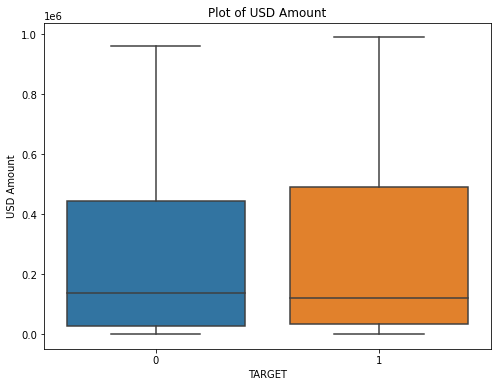

In [996]:
# comparing Target 1 and 0 customers based on USD Amount
bivariate_box(inp0[inp0['USD Amount']<1000000],'USD Amount')

##### Trasaction amount is distributed almost equally amoung Targets

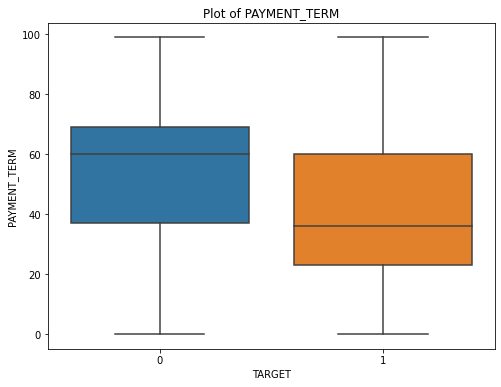

In [997]:
bivariate_box(inp0[inp0['PAYMENT_TERM']<100],'PAYMENT_TERM')

##### Default payments happen generally when payment term is shorter

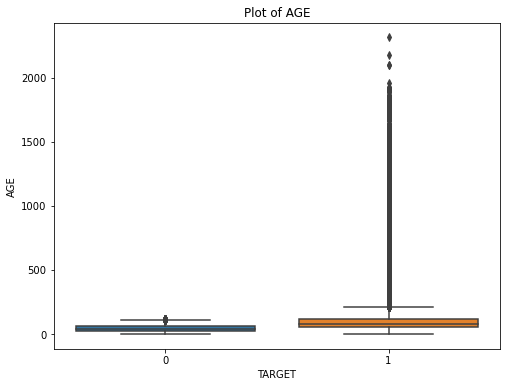

In [998]:
bivariate_box(inp0,'AGE')

In [999]:
tar1['AGE_POST_DUE'] = tar1['RECEIPT_DATE'] - tar1['DUE_DATE']
tar1['AGE_POST_DUE'] = tar1['AGE_POST_DUE'].dt.days

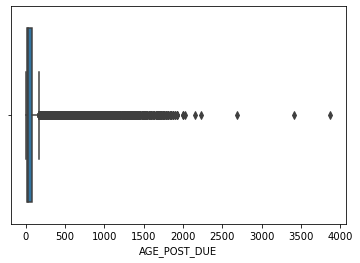

In [1000]:
sns.boxplot(tar1['AGE_POST_DUE'])
plt.show()

In [1001]:
tar1['AGE_POST_DUE'].describe()

count    60910.000000
mean       107.349483
std        227.628518
min          1.000000
25%         12.000000
50%         30.000000
75%         76.000000
max       3873.000000
Name: AGE_POST_DUE, dtype: float64

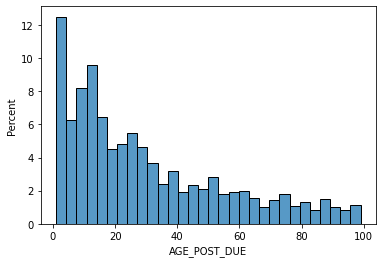

In [1002]:
sns.histplot(tar1[tar1['AGE_POST_DUE']<100]['AGE_POST_DUE'],bins=30, stat='percent')
plt.show()

##### 75% of the people who default make payment within 78 days post Due date

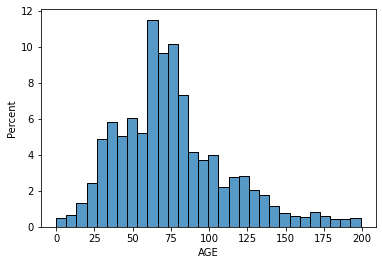

In [1003]:
sns.histplot(tar1[tar1['AGE']<200]['AGE'],bins=30, stat='percent')
plt.show()

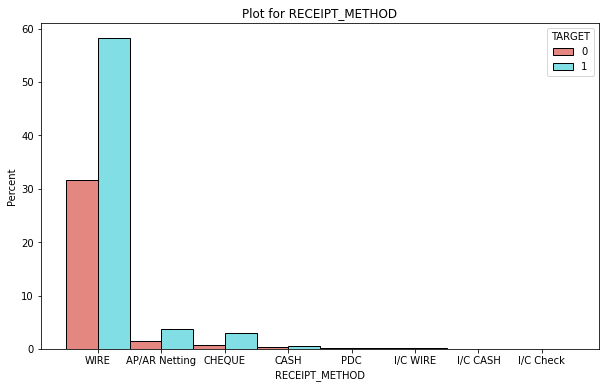

In [1004]:
bivariate_his('RECEIPT_METHOD')

##### Defaulters make payment on all modes equally

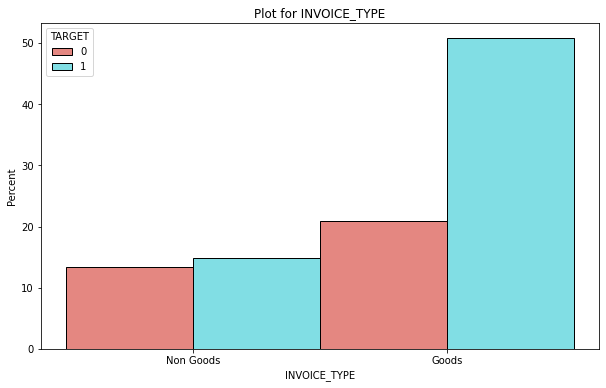

In [1005]:
bivariate_his('INVOICE_TYPE')

##### Goods category has generally higher chances of deatulting compared to Non-Goods

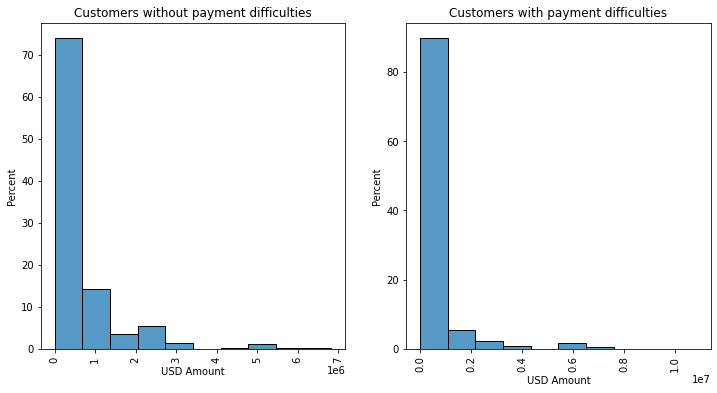

In [1006]:
bivariate_his_split('USD Amount')

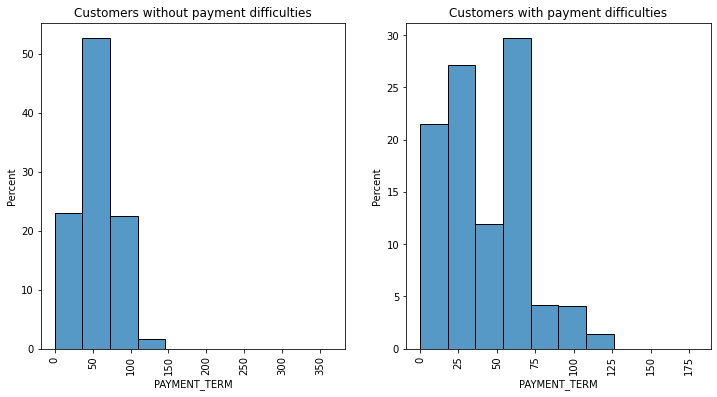

In [1007]:
bivariate_his_split('PAYMENT_TERM')

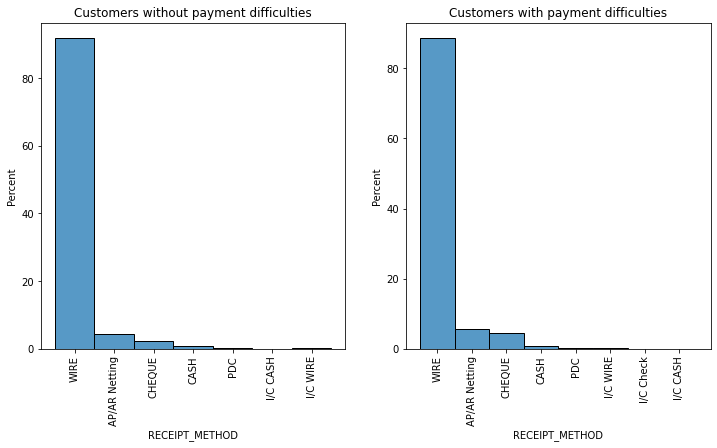

In [1008]:
bivariate_his_split('RECEIPT_METHOD')

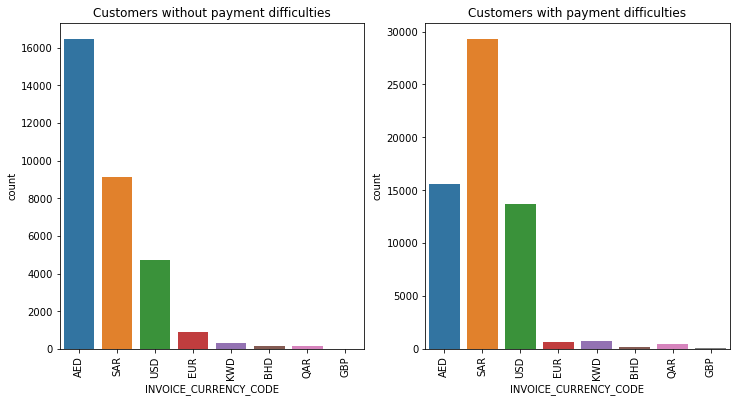

In [1009]:
bivariate_count('INVOICE_CURRENCY_CODE')

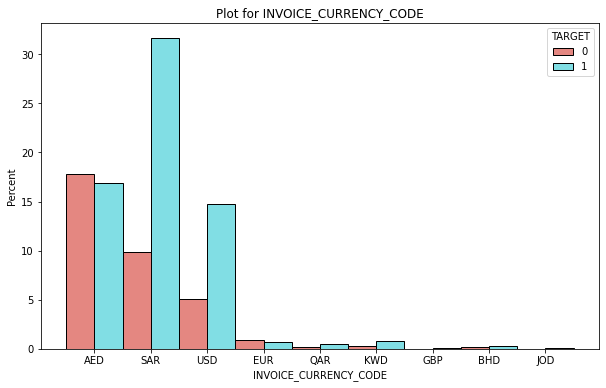

In [1010]:
bivariate_his('INVOICE_CURRENCY_CODE')

##### SAR and USD have more defulters than other currencies, AED has less number of defaulters

In [1011]:
grouped_df = inp0.groupby('CUSTOMER_NUMBER')['TARGET'].mean()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CUSTOMER_NUMBER,TARGET
0,10100,1.000000
1,10320,0.714286
2,10360,0.553191
3,1044,0.719912
4,1076,0.472000


In [1012]:
grouped_df[grouped_df['TARGET']==0]

,CUSTOMER_NUMBER,TARGET
10,1201,0.0
27,15762,0.0
53,20867,0.0
60,20894,0.0
67,20952,0.0
...,...,...
1019,52800,0.0
1021,52820,0.0
1022,52940,0.0
1027,5720,0.0


#### 149 customers have no history of defaulting

### <font color=blue>3. Customer Segmentation using Clustering</font>

In [1013]:
retail_df = inp0.copy()

In [1014]:
retail_df.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,AGE,TARGET
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.63040,14200000001,2020-11-02,2020-12-30,58,INV,AED,Non Goods,169,1
1,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.21133,99200000043,2020-12-29,2021-01-28,30,INV,SAR,Non Goods,33,1
2,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99210000003,2021-01-30,2021-03-01,30,INV,SAR,Non Goods,1,0
3,WIRE,FARO Corp,1409,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000038,2020-12-15,2021-01-14,30,INV,SAR,Non Goods,47,1
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.60971,99200000039,2020-12-15,2021-01-14,30,INV,SAR,Non Goods,47,1


In [1015]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92788 entries, 0 to 93936
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         92788 non-null  object        
 1   CUSTOMER_NAME          92788 non-null  object        
 2   CUSTOMER_NUMBER        92788 non-null  object        
 3   RECEIPT_DOC_NO         92759 non-null  float64       
 4   RECEIPT_DATE           92788 non-null  datetime64[ns]
 5   CLASS                  92788 non-null  object        
 6   CURRENCY_CODE          92788 non-null  object        
 7   Local Amount           92788 non-null  float64       
 8   USD Amount             92788 non-null  float64       
 9   INVOICE_ALLOCATED      92788 non-null  object        
 10  INVOICE_CREATION_DATE  92788 non-null  datetime64[ns]
 11  DUE_DATE               92788 non-null  datetime64[ns]
 12  PAYMENT_TERM           92788 non-null  int64         
 13  I

In [1016]:
#(retail_df["RECEIPT_DATE"][0]-retail_df["INVOICE_CREATION_DATE"][0]).days

In [1017]:
#retail_df['NO_OF_DAYS_PAYMENT'] = retail_df['AGE']

In [1018]:
#retail_df['NO_OF_DAYS_PAYMENT'] = retail_df.apply(lambda x: x['RECEIPT_DATE']-x['INVOICE_CREATION_DATE'], axis=1)
#retail_df
#Note: Above code gives new column as 'Object' type. Let's convert it to 'int' type
#retail_df['NO_OF_DAYS_PAYMENT'] = retail_df['NO_OF_DAYS_PAYMENT'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
#retail_df

#### AGE column represents the number of days taken for payment post invoice generation

#### Calculating Mean and Standard Deviation for each customer for making the payment

In [1019]:
customer_number_list = list(retail_df['CUSTOMER_NUMBER'].unique())
#There are 1054 customers in total
mean_days_payment = []
std_days_payment = []
#New dataframe with unique customer list
cust_segment_df = pd.DataFrame(columns = ['CUSTOMER_NUMBER', 'MEAN_DAYS_PAYMENT', 'STD_DAYS_PAYMENT'])
#now calculating Mean and STD of payment_days of each customer
for each in customer_number_list:
    dummy_df = retail_df[retail_df["CUSTOMER_NUMBER"] == each]
    dummy_df.reset_index(drop=True)
    if len(dummy_df) > 1: #when each customer has at least two(i.e. two or more) transactions
        mean_days_payment.append(dummy_df["AGE"].mean())
        std_days_payment.append(dummy_df["AGE"].std())
    else: #when the customer has only one transaction
        mean_days_payment.append(dummy_df["AGE"].mean())
        std_days_payment.append(0) #STD of a single value is zero

#Storing above results into the new dataframe
cust_segment_df['CUSTOMER_NUMBER'] = customer_number_list
cust_segment_df['MEAN_DAYS_PAYMENT'] = mean_days_payment
cust_segment_df['STD_DAYS_PAYMENT'] = std_days_payment

In [1020]:
cust_segment_df

,CUSTOMER_NUMBER,MEAN_DAYS_PAYMENT,STD_DAYS_PAYMENT
0,37403,99.000000,64.490309
1,4003,52.588235,35.855932
2,1409,151.501837,256.743823
3,15768,138.138346,229.819959
4,20884,146.775362,101.357935
...,...,...,...
1043,1713,180.500000,82.731493
1044,49420,135.444444,38.665589
1045,50801,72.857143,19.187049
1046,51461,9.000000,1.732051


#### Note: Outlier treatment has not been performed

#### Rescaling: Standardization

In [1021]:
# 2. rescaling
rfm_df = cust_segment_df[['MEAN_DAYS_PAYMENT', 'STD_DAYS_PAYMENT']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(1048, 2)

In [1022]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['MEAN_DAYS_PAYMENT', 'STD_DAYS_PAYMENT']
rfm_df_scaled.head()

,MEAN_DAYS_PAYMENT,STD_DAYS_PAYMENT
0,-0.002927,0.254778
1,-0.334093,-0.100637
2,0.371693,2.641068
3,0.276340,2.306884
4,0.337968,0.712387


In [1023]:
rfm_df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048 entries, 0 to 1047
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEAN_DAYS_PAYMENT  1048 non-null   float64
 1   STD_DAYS_PAYMENT   1048 non-null   float64
dtypes: float64(2)
memory usage: 16.5 KB


### Modelling: K-Means clustering

In [1024]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [1025]:
kmeans.labels_

array([3, 1, 2, ..., 1, 1, 1])

#### Finding the optimal no of clusters

#### A) SSD(Sum of Squared Distances)

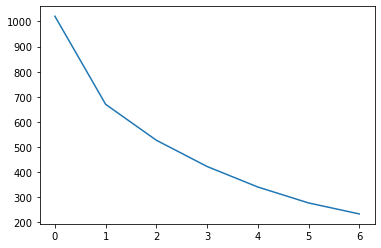

In [1026]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

#### Note: From above graph, the curve is stabilizing after index '3'. Means optimal k is 5

In [1027]:
# final model with k=5
kmeans = KMeans(n_clusters=5, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=5)

In [1028]:
kmeans.labels_

array([1, 0, 4, ..., 0, 0, 0])

In [1029]:
#Assign the label to original dataframe
cust_segment_df['SEGMENT_ID'] = kmeans.labels_
cust_segment_df.head()

,CUSTOMER_NUMBER,MEAN_DAYS_PAYMENT,STD_DAYS_PAYMENT,SEGMENT_ID
0,37403,99.000000,64.490309,1
1,4003,52.588235,35.855932,0
2,1409,151.501837,256.743823,4
3,15768,138.138346,229.819959,4
4,20884,146.775362,101.357935,1


In [1030]:
cust_segment_df.SEGMENT_ID.value_counts()

0    747
1    204
4     53
2     32
3     12
Name: SEGMENT_ID, dtype: int64

#### Plotting above results 

<AxesSubplot:xlabel='SEGMENT_ID', ylabel='MEAN_DAYS_PAYMENT'>

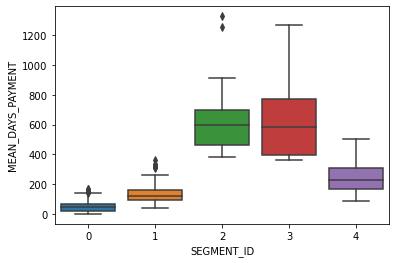

In [1031]:
# plot: SEGMENT vs MEAN
sns.boxplot(x='SEGMENT_ID', y='MEAN_DAYS_PAYMENT', data=cust_segment_df)

<AxesSubplot:xlabel='SEGMENT_ID', ylabel='STD_DAYS_PAYMENT'>

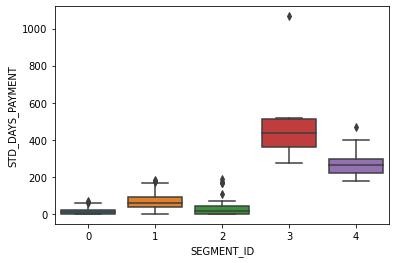

In [1032]:
# plot: SEGMENT vs STD
sns.boxplot(x='SEGMENT_ID', y='STD_DAYS_PAYMENT', data=cust_segment_df)

#### Note: From Above Graphs: SEGMENTS '1' and '4' are best customers having less MEAN and STD

### <font color=blue>4. Model Building and Evaluation</font>

#### Merging the datasets and preparing for modeling

In [1033]:
inp0 = pd.merge(inp0, cust_segment_df, on='CUSTOMER_NUMBER')

In [1034]:
inp0.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,...,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE,AGE,TARGET,MEAN_DAYS_PAYMENT,STD_DAYS_PAYMENT,SEGMENT_ID
0,WIRE,C EA Corp,37403,1.421000e+10,2021-04-20,PMT,USD,370990.92,101018.630400,14200000001,...,2020-12-30,58,INV,AED,Non Goods,169,1,99.000000,64.490309,1
1,WIRE,C EA Corp,37403,1.270000e+11,2021-05-19,PMT,AED,2859.09,2859.090000,1.2721E+11,...,2021-05-30,53,INV,AED,Non Goods,42,0,99.000000,64.490309,1
2,WIRE,C EA Corp,37403,2.410000e+11,2021-02-20,PMT,AED,38.85,10.578625,2.412E+11,...,2020-12-26,30,INV,AED,Non Goods,86,1,99.000000,64.490309,1
3,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,183750.00,48990.211330,99200000043,...,2021-01-28,30,INV,SAR,Non Goods,33,1,52.588235,35.855932,0
4,WIRE,RADW Corp,4003,9.921000e+10,2021-01-31,PMT,SAR,157500.00,41991.609710,99210000003,...,2021-03-01,30,INV,SAR,Non Goods,1,0,52.588235,35.855932,0


In [1035]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92788 entries, 0 to 92787
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         92788 non-null  object        
 1   CUSTOMER_NAME          92788 non-null  object        
 2   CUSTOMER_NUMBER        92788 non-null  object        
 3   RECEIPT_DOC_NO         92759 non-null  float64       
 4   RECEIPT_DATE           92788 non-null  datetime64[ns]
 5   CLASS                  92788 non-null  object        
 6   CURRENCY_CODE          92788 non-null  object        
 7   Local Amount           92788 non-null  float64       
 8   USD Amount             92788 non-null  float64       
 9   INVOICE_ALLOCATED      92788 non-null  object        
 10  INVOICE_CREATION_DATE  92788 non-null  datetime64[ns]
 11  DUE_DATE               92788 non-null  datetime64[ns]
 12  PAYMENT_TERM           92788 non-null  int64         
 13  I

In [1036]:
## convert segment to String for modeling

inp0["SEGMENT_ID"] = inp0["SEGMENT_ID"].astype(str)

##### Dropping unwanted columns

In [1037]:
## remove unwated columns, create a list of columns that can be removed from the modeling
unwanted_cols=['RECEIPT_METHOD','CUSTOMER_NAME','RECEIPT_DOC_NO','RECEIPT_DATE','CLASS','CURRENCY_CODE',
               'Local Amount','INVOICE_ALLOCATED','INVOICE_CREATION_DATE','DUE_DATE','INVOICE_TYPE', 'AGE',  
               'MEAN_DAYS_PAYMENT', 'STD_DAYS_PAYMENT'
]

In [1038]:
inp0 = inp0.drop(unwanted_cols, axis=1)

In [1039]:
X = inp0.drop(['TARGET','CUSTOMER_NUMBER'], axis=1)

In [1040]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92788 entries, 0 to 92787
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   USD Amount             92788 non-null  float64
 1   PAYMENT_TERM           92788 non-null  int64  
 2   INVOICE_CLASS          92788 non-null  object 
 3   INVOICE_CURRENCY_CODE  92788 non-null  object 
 4   SEGMENT_ID             92788 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ MB


#### creating dummy variables for categorical values

In [1041]:
curr = pd.get_dummies(X['INVOICE_CURRENCY_CODE'],drop_first=True).add_prefix('curr_')
segment = pd.get_dummies(X['SEGMENT_ID'],drop_first=True).add_prefix('segment_')
invoice = pd.get_dummies(X['INVOICE_CLASS'],drop_first=True).add_prefix('invoice_')

In [1042]:
X=pd.concat([X,curr],axis=1)
X=pd.concat([X,segment],axis=1)
X=pd.concat([X,invoice],axis=1)

In [1043]:
X.drop(['INVOICE_CURRENCY_CODE'], axis = 1, inplace = True)
X.drop(['SEGMENT_ID'], axis = 1, inplace = True)
X.drop(['INVOICE_CLASS'], axis = 1, inplace = True)

In [1044]:
X.head()

,USD Amount,PAYMENT_TERM,curr_BHD,curr_EUR,curr_GBP,curr_JOD,curr_KWD,curr_QAR,curr_SAR,curr_USD,segment_1,segment_2,segment_3,segment_4,invoice_DM,invoice_INV
0,101018.630400,58,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,2859.090000,53,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,10.578625,30,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,48990.211330,30,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,41991.609710,30,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [1045]:
y = inp0['TARGET']

In [1046]:
y.value_counts()

1    60910
0    31878
Name: TARGET, dtype: int64

### Applying Random forest classification

In [1047]:
from sklearn.model_selection import train_test_split

In [1048]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [1049]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((64951, 16), (27837, 16))

In [1050]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64951 entries, 78268 to 15795
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USD Amount    64951 non-null  float64
 1   PAYMENT_TERM  64951 non-null  int64  
 2   curr_BHD      64951 non-null  uint8  
 3   curr_EUR      64951 non-null  uint8  
 4   curr_GBP      64951 non-null  uint8  
 5   curr_JOD      64951 non-null  uint8  
 6   curr_KWD      64951 non-null  uint8  
 7   curr_QAR      64951 non-null  uint8  
 8   curr_SAR      64951 non-null  uint8  
 9   curr_USD      64951 non-null  uint8  
 10  segment_1     64951 non-null  uint8  
 11  segment_2     64951 non-null  uint8  
 12  segment_3     64951 non-null  uint8  
 13  segment_4     64951 non-null  uint8  
 14  invoice_DM    64951 non-null  uint8  
 15  invoice_INV   64951 non-null  uint8  
dtypes: float64(1), int64(1), uint8(14)
memory usage: 2.4 MB


In [1051]:
rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=10, max_features=10, min_samples_leaf=10)

In [1052]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10,
                       n_estimators=10, random_state=42)

In [1053]:
y_train_pred = rf.predict(X_train)

#### Checking the performance of the model on train data

In [1054]:
accuracy_score(y_train, y_train_pred)

0.8301642776862558

In [1055]:
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[14178,  8153],
       [ 2878, 39742]], dtype=int64)

In [1056]:
print(sklearn.metrics.classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.83      0.63      0.72     22331
           1       0.83      0.93      0.88     42620

    accuracy                           0.83     64951
   macro avg       0.83      0.78      0.80     64951
weighted avg       0.83      0.83      0.82     64951



In [1057]:
rf.estimators_[0]

DecisionTreeClassifier(max_depth=10, max_features=10, min_samples_leaf=10,
                       random_state=1608637542)

In [1058]:
sample_tree = rf.estimators_[4]

#### Predicting the model on test data

In [1059]:
# Predict the test set labels
y_test_pred = rf.predict(X_test)

In [1060]:
accuracy_score(y_test, y_test_pred)

0.8260229191364012

In [1061]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[ 6068,  3479],
       [ 1364, 16926]], dtype=int64)

In [1062]:
print(sklearn.metrics.classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.82      0.64      0.71      9547
           1       0.83      0.93      0.87     18290

    accuracy                           0.83     27837
   macro avg       0.82      0.78      0.79     27837
weighted avg       0.83      0.83      0.82     27837



#### Accuracy and other parameters are similar for train and test indicating no over-fitting

In [1063]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": rf.feature_importances_
})

In [1064]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
1,PAYMENT_TERM,0.455277
0,USD Amount,0.265619
13,segment_4,0.083679
8,curr_SAR,0.069747
10,segment_1,0.068180
9,curr_USD,0.020088
12,segment_3,0.014649
3,curr_EUR,0.013608
15,invoice_INV,0.004441
11,segment_2,0.001712


### Hyperparameter tuning

In [1065]:
from sklearn.model_selection import GridSearchCV

In [1066]:
classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [1067]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_leaf': [10, 20, 50],
    'n_estimators': [10, 20, 30, 50]
}

In [1068]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [1069]:
%%time
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
CPU times: total: 6.16 s
Wall time: 20.9 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 20],
                         'min_samples_leaf': [10, 20, 50],
                         'n_estimators': [10, 20, 30, 50]},
             scoring='accuracy', verbose=1)

In [1070]:
grid_search.best_score_

0.8422657242396

In [1071]:
rf_best = grid_search.best_estimator_

In [1072]:
rf_best

RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=50,
                       n_jobs=-1, random_state=42)

#### Rerun the training with new parameters

In [1073]:
rf = RandomForestClassifier(max_depth=20, max_features=10, min_samples_leaf=10,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [1074]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=10, min_samples_leaf=10,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [1075]:
y_train_pred = rf.predict(X_train)

In [1076]:
accuracy_score(y_train, y_train_pred)

0.8762143769918862

In [1077]:
print(sklearn.metrics.classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.88      0.74      0.80     22331
           1       0.87      0.95      0.91     42620

    accuracy                           0.88     64951
   macro avg       0.88      0.84      0.86     64951
weighted avg       0.88      0.88      0.87     64951



In [1078]:
# Predict the test set labels
y_pred = rf.predict(X_test)

In [1079]:
accuracy_score(y_test, y_pred)

0.8619822538348242

#### Accuracy and other metrics have improved after hyper parameter tuning

In [1080]:
print(sklearn.metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78      9547
           1       0.86      0.94      0.90     18290

    accuracy                           0.86     27837
   macro avg       0.86      0.83      0.84     27837
weighted avg       0.86      0.86      0.86     27837



#### Identifying the important features

In [1081]:
rf.feature_importances_

array([3.66345219e-01, 3.88859611e-01, 1.08155698e-03, 1.23358749e-02,
       2.25103448e-04, 5.86179476e-05, 2.22222463e-03, 3.60377542e-04,
       6.51042647e-02, 2.12128805e-02, 5.55878402e-02, 2.34708457e-03,
       1.26335912e-02, 6.54944816e-02, 5.73658917e-04, 5.55761249e-03])

<BarContainer object of 14 artists>

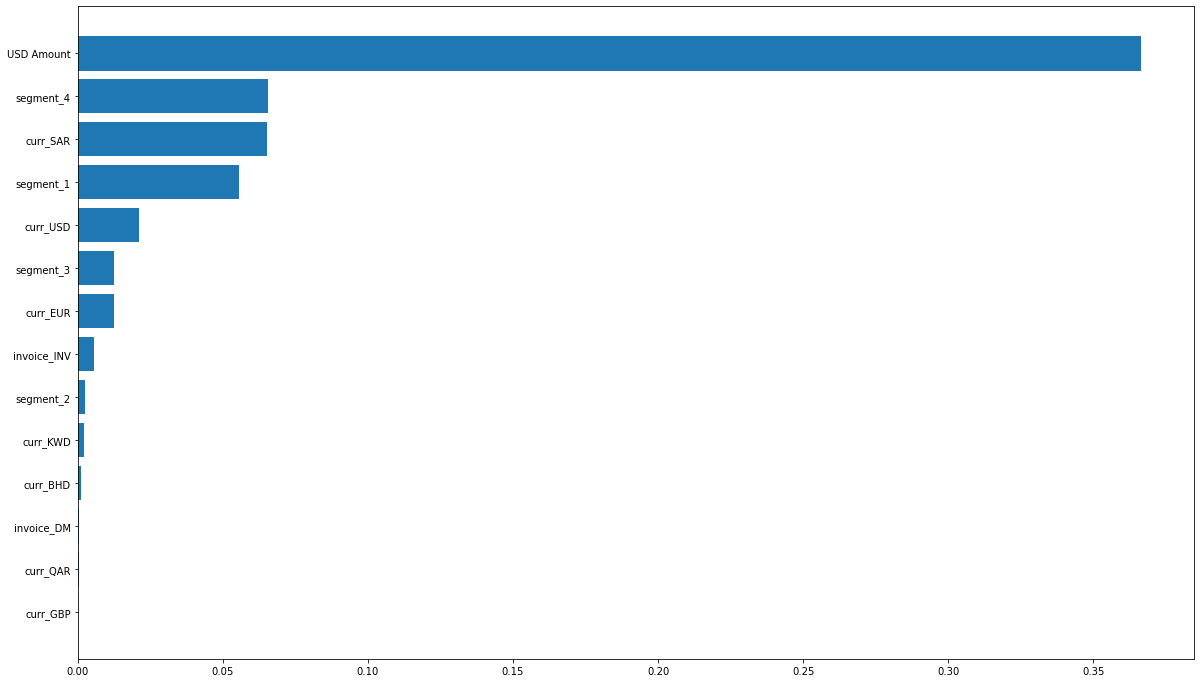

In [1082]:
plt.figure(figsize=(20,12))
sorted_idx = rf.feature_importances_.argsort()
filter_arr = sorted_idx[-15:-1]
#sorted_idx  = filter(lambda sorted_idx: sorted_idx >= 0.01, sorted_idx)
plt.barh(X_train.columns[filter_arr], rf.feature_importances_[filter_arr])

In [1083]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

### <font color=blue> 5. Analysing Open Invoice data</font>

In [1084]:
#read the data set of "application_data" in inp0.
inp1= pd.read_csv("Open_Invoice_data.csv",encoding= 'unicode_escape')

In [1085]:
inp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88204 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88204 non-null  object 
 1   Customer Type         88204 non-null  object 
 2   Customer_Name         88204 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88195 non-null  object 
 5   Transaction Date      88204 non-null  object 
 6   Payment Term          88204 non-null  object 
 7   Due Date              88204 non-null  object 
 8   Transaction Currency  88204 non-null  object 
 9   Local Amount          88204 non-null  object 
 10  Transaction Class     88204 non-null  object 
 11  AGE                   88204 non-null  int64  
 12  USD Amount            88204 non-null  object 
 13  INV_CREATION_DATE     88204 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 9.4+ MB


In [1086]:
inp1.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [1087]:
inp1.shape

(88204, 14)

In [1088]:
#identify columns with  null values
empty_columns_prev= inp1.isnull().sum()*100/len(inp1)
empty_columns_prev

AS_OF_DATE              0.000000
Customer Type           0.000000
Customer_Name           0.000000
Customer Account No     0.003401
Transaction Number      0.010204
Transaction Date        0.000000
Payment Term            0.000000
Due Date                0.000000
Transaction Currency    0.000000
Local Amount            0.000000
Transaction Class       0.000000
AGE                     0.000000
USD Amount              0.000000
INV_CREATION_DATE       0.000000
dtype: float64

In [1089]:
#dropping customer account column with null
inp1 = inp1.dropna(subset=['Customer Account No'])

In [1090]:
inp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88201 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88201 non-null  object 
 1   Customer Type         88201 non-null  object 
 2   Customer_Name         88201 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88192 non-null  object 
 5   Transaction Date      88201 non-null  object 
 6   Payment Term          88201 non-null  object 
 7   Due Date              88201 non-null  object 
 8   Transaction Currency  88201 non-null  object 
 9   Local Amount          88201 non-null  object 
 10  Transaction Class     88201 non-null  object 
 11  AGE                   88201 non-null  int64  
 12  USD Amount            88201 non-null  object 
 13  INV_CREATION_DATE     88201 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 10.1+ MB


In [1091]:
## Transaction date seems to be a better fit than Inv generation date as Invoice generation is always late
inp1['Transaction Date'] = pd.to_datetime(inp1['Transaction Date']).dt.date

In [1092]:
inp1['Due Date'] = pd.to_datetime(inp1['Due Date']).dt.date

In [1093]:
inp1['PAYMENT_TERM'] = inp1['Due Date'] - inp1['Transaction Date']

In [1094]:
inp1['PAYMENT_TERM'] =inp1['PAYMENT_TERM'].dt.days

In [1095]:
inp1['PAYMENT_TERM'].describe()

count    88201.000000
mean        29.829118
std         71.873618
min       -333.000000
25%          0.000000
50%         30.000000
75%         60.000000
max       1980.000000
Name: PAYMENT_TERM, dtype: float64

In [1096]:
#Check all entries of payment term that is negative
inp1[inp1['PAYMENT_TERM']<0]

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE,PAYMENT_TERM
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,2022-04-01,15 Days from Inv Date,2022-01-19,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49,-72
28,04-APR-2022 01:07:01,Related Party,FITR Corp,1409.0,100220000070,2022-08-02,30 Days from EOM,2022-03-30,USD,"2,300",INVOICE,6,"2,300",2/8/2022 18:09,-125
29,04-APR-2022 01:07:01,Related Party,FITR Corp,1409.0,100220000071,2022-08-02,30 Days from EOM,2022-03-30,USD,"2,000",INVOICE,6,"2,000",2/8/2022 18:09,-125
30,04-APR-2022 01:07:01,Related Party,FITR Corp,1409.0,100220000072,2022-08-02,30 Days from EOM,2022-03-30,USD,"2,500",INVOICE,6,"2,500",2/8/2022 18:09,-125
31,04-APR-2022 01:07:01,Related Party,FITR Corp,1409.0,100220000073,2022-08-02,30 Days from EOM,2022-03-30,USD,"2,300",INVOICE,6,"2,300",2/8/2022 18:09,-125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88175,04-APR-2022 01:07:01,3rd Party,SAUD Corp,23136.0,165200000404,2020-06-10,60 Days from Inv Date,2020-05-12,USD,"2,315",INVOICE,486,"2,315",10/6/2020 12:38,-29
88176,04-APR-2022 01:07:01,3rd Party,SAUD Corp,23136.0,165200000408,2020-07-10,60 Days from Inv Date,2020-06-12,USD,"1,477",INVOICE,485,"1,477",10/7/2020 16:11,-28
88186,04-APR-2022 01:07:01,3rd Party,SAUD Corp,23136.0,165220000032,2022-07-03,60 Days from Inv Date,2022-06-05,USD,"114,039",INVOICE,-31,"114,039",3/7/2022 9:58,-28
88190,04-APR-2022 01:07:01,3rd Party,SCEN Corp,40146.0,165210000067,2021-08-05,60 Days from Inv Date,2021-07-07,USD,"17,339",INVOICE,272,"17,339",5/8/2021 12:24,-29


#### Resetting the Payment term to zero wherever it is negative

In [1097]:
inp1['PAYMENT_TERM'] = np.where(inp1['PAYMENT_TERM']<0, 0, inp1['PAYMENT_TERM'])

In [1098]:
inp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88201 entries, 0 to 88203
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            88201 non-null  object 
 1   Customer Type         88201 non-null  object 
 2   Customer_Name         88201 non-null  object 
 3   Customer Account No   88201 non-null  float64
 4   Transaction Number    88192 non-null  object 
 5   Transaction Date      88201 non-null  object 
 6   Payment Term          88201 non-null  object 
 7   Due Date              88201 non-null  object 
 8   Transaction Currency  88201 non-null  object 
 9   Local Amount          88201 non-null  object 
 10  Transaction Class     88201 non-null  object 
 11  AGE                   88201 non-null  int64  
 12  USD Amount            88201 non-null  object 
 13  INV_CREATION_DATE     88201 non-null  object 
 14  PAYMENT_TERM          88201 non-null  int64  
dtypes: float64(1), int6

#### Drop all records with AGE positive as we only need to deal with the ones where AGE is negative

In [1099]:
inp1 = inp1[inp1['AGE']<0]

### Preparing to use this dataset as a test data 

In [1100]:
inp1.shape

(28080, 15)

In [1101]:
unwanted_cols=['AS_OF_DATE','Customer Type', 'Customer_Name',
                    'Transaction Number', 'Transaction Date', 'Due Date','INV_CREATION_DATE', 'Local Amount','AGE',
                   'INV_CREATION_DATE', 'Payment Term'
              ]
                    

In [1102]:
inp1.drop(columns=unwanted_cols,inplace=True)

In [1103]:
inp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28080 entries, 2 to 88189
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer Account No   28080 non-null  float64
 1   Transaction Currency  28080 non-null  object 
 2   Transaction Class     28080 non-null  object 
 3   USD Amount            28080 non-null  object 
 4   PAYMENT_TERM          28080 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.3+ MB


#### Rename columns to make it consistent with the train data

In [1104]:
inp1.rename(columns ={'Customer Account No':'CUSTOMER_NUMBER', 'Transaction Currency':'INVOICE_CURRENCY_CODE', 
                      'Transaction Class': 'INVOICE_CLASS'}, inplace=True)

In [1105]:
inp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28080 entries, 2 to 88189
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_NUMBER        28080 non-null  float64
 1   INVOICE_CURRENCY_CODE  28080 non-null  object 
 2   INVOICE_CLASS          28080 non-null  object 
 3   USD Amount             28080 non-null  object 
 4   PAYMENT_TERM           28080 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.3+ MB


In [1106]:
inp1['INVOICE_CLASS'].value_counts()

INVOICE       27770
DEBIT NOTE      285
PAYMENT          25
Name: INVOICE_CLASS, dtype: int64

In [1107]:
inp0['INVOICE_CLASS'].value_counts()

INV    87290
CM      4946
DM       552
Name: INVOICE_CLASS, dtype: int64

In [1108]:
## Modifying the invoice_class categories to make it consistent with train data

inp1['INVOICE_CLASS'] = inp1['INVOICE_CLASS'].replace(['INVOICE','DEBIT NOTE','PAYMENT'],['INV','DM','CM'])

In [1109]:
inp1.head()

,CUSTOMER_NUMBER,INVOICE_CURRENCY_CODE,INVOICE_CLASS,USD Amount,PAYMENT_TERM
2,23152.0,USD,INV,"2,000",30
4,7530.0,AED,INV,"3,800",58
5,7530.0,AED,INV,"1,264",58
6,7530.0,AED,INV,"25,858",46
7,7530.0,AED,INV,"39,873",46


#### Convert data types

In [1110]:
inp1["CUSTOMER_NUMBER"] = inp1["CUSTOMER_NUMBER"].astype('Int64').astype('str')

In [1111]:
inp1['USD Amount'] = inp1['USD Amount'].str.replace(',', '').astype(float)

In [1112]:
inp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28080 entries, 2 to 88189
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_NUMBER        28080 non-null  object 
 1   INVOICE_CURRENCY_CODE  28080 non-null  object 
 2   INVOICE_CLASS          28080 non-null  object 
 3   USD Amount             28080 non-null  float64
 4   PAYMENT_TERM           28080 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.3+ MB


In [1113]:
inp1.head()

,CUSTOMER_NUMBER,INVOICE_CURRENCY_CODE,INVOICE_CLASS,USD Amount,PAYMENT_TERM
2,23152,USD,INV,2000.0,30
4,7530,AED,INV,3800.0,58
5,7530,AED,INV,1264.0,58
6,7530,AED,INV,25858.0,46
7,7530,AED,INV,39873.0,46


#### Drop currency codes that are not in the train data

In [1114]:
inp0.INVOICE_CURRENCY_CODE.value_counts()

SAR    38491
AED    32119
USD    18389
EUR     1518
KWD     1088
QAR      611
BHD      400
GBP      134
JOD       38
Name: INVOICE_CURRENCY_CODE, dtype: int64

In [1115]:
inp1.INVOICE_CURRENCY_CODE.value_counts()

SAR    10148
AED     8895
USD     4136
KWD     2890
BHD      697
QAR      503
EGP      403
EUR      384
GBP       12
JOD        5
OMR        4
HKD        1
SGD        1
ZAR        1
Name: INVOICE_CURRENCY_CODE, dtype: int64

In [1116]:
indexCurr = inp1[ (inp1['INVOICE_CURRENCY_CODE'] == 'EGP') | (inp1['INVOICE_CURRENCY_CODE'] == 'HKD') |
                 (inp1['INVOICE_CURRENCY_CODE'] == 'OMR') |  (inp1['INVOICE_CURRENCY_CODE'] == 'SGD')].index
inp1.drop(indexCurr , inplace=True)

In [1117]:
inp1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27671 entries, 2 to 88189
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_NUMBER        27671 non-null  object 
 1   INVOICE_CURRENCY_CODE  27671 non-null  object 
 2   INVOICE_CLASS          27671 non-null  object 
 3   USD Amount             27671 non-null  float64
 4   PAYMENT_TERM           27671 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.3+ MB


#### Adding Segment ID for each customer

In [1118]:
inp2 = pd.merge(inp1, cust_segment_df, on='CUSTOMER_NUMBER')

In [1119]:
inp2.head()

,CUSTOMER_NUMBER,INVOICE_CURRENCY_CODE,INVOICE_CLASS,USD Amount,PAYMENT_TERM,MEAN_DAYS_PAYMENT,STD_DAYS_PAYMENT,SEGMENT_ID
0,23152,USD,INV,2000.0,30,67.130208,69.369024,1
1,23152,SAR,INV,21462.0,30,67.130208,69.369024,1
2,23152,USD,INV,36866.0,30,67.130208,69.369024,1
3,23152,USD,INV,372768.0,30,67.130208,69.369024,1
4,23152,SAR,INV,1210.0,30,67.130208,69.369024,1


In [1120]:
inp2.SEGMENT_ID.value_counts()

0    10561
4     9719
1     4913
3      283
2       13
Name: SEGMENT_ID, dtype: int64

In [1121]:
inp2.drop(columns=['MEAN_DAYS_PAYMENT','STD_DAYS_PAYMENT'], inplace=True)

In [1122]:
inp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25489 entries, 0 to 25488
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_NUMBER        25489 non-null  object 
 1   INVOICE_CURRENCY_CODE  25489 non-null  object 
 2   INVOICE_CLASS          25489 non-null  object 
 3   USD Amount             25489 non-null  float64
 4   PAYMENT_TERM           25489 non-null  int64  
 5   SEGMENT_ID             25489 non-null  int32  
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 1.3+ MB


In [1123]:
inp0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92788 entries, 0 to 92787
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CUSTOMER_NUMBER        92788 non-null  object 
 1   USD Amount             92788 non-null  float64
 2   PAYMENT_TERM           92788 non-null  int64  
 3   INVOICE_CLASS          92788 non-null  object 
 4   INVOICE_CURRENCY_CODE  92788 non-null  object 
 5   TARGET                 92788 non-null  int32  
 6   SEGMENT_ID             92788 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 5.3+ MB


### Testing with the model

In [1124]:
X_test2 = inp2.copy()

In [1125]:
# creating dummy variables for categorical values
curr = pd.get_dummies(X_test2['INVOICE_CURRENCY_CODE'],drop_first=True).add_prefix('curr_')
segment = pd.get_dummies(X_test2['SEGMENT_ID'],drop_first=True).add_prefix('segment_')
invoice = pd.get_dummies(X_test2['INVOICE_CLASS'],drop_first=True).add_prefix('invoice_')

In [1126]:
X_test2=pd.concat([X_test2,curr],axis=1)
X_test2=pd.concat([X_test2,segment],axis=1)
X_test2=pd.concat([X_test2,invoice],axis=1)

In [1127]:
X_test2.drop(['INVOICE_CURRENCY_CODE'], axis = 1, inplace = True)
X_test2.drop(['SEGMENT_ID'], axis = 1, inplace = True)
X_test2.drop(['INVOICE_CLASS'], axis = 1, inplace = True)

In [1128]:
X_test2.drop(['CUSTOMER_NUMBER'], axis = 1, inplace = True)

In [1129]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25489 entries, 0 to 25488
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USD Amount    25489 non-null  float64
 1   PAYMENT_TERM  25489 non-null  int64  
 2   curr_BHD      25489 non-null  uint8  
 3   curr_EUR      25489 non-null  uint8  
 4   curr_GBP      25489 non-null  uint8  
 5   curr_JOD      25489 non-null  uint8  
 6   curr_KWD      25489 non-null  uint8  
 7   curr_QAR      25489 non-null  uint8  
 8   curr_SAR      25489 non-null  uint8  
 9   curr_USD      25489 non-null  uint8  
 10  segment_1     25489 non-null  uint8  
 11  segment_2     25489 non-null  uint8  
 12  segment_3     25489 non-null  uint8  
 13  segment_4     25489 non-null  uint8  
 14  invoice_DM    25489 non-null  uint8  
 15  invoice_INV   25489 non-null  uint8  
dtypes: float64(1), int64(1), uint8(14)
memory usage: 945.9 KB


In [1130]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64951 entries, 78268 to 15795
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USD Amount    64951 non-null  float64
 1   PAYMENT_TERM  64951 non-null  int64  
 2   curr_BHD      64951 non-null  uint8  
 3   curr_EUR      64951 non-null  uint8  
 4   curr_GBP      64951 non-null  uint8  
 5   curr_JOD      64951 non-null  uint8  
 6   curr_KWD      64951 non-null  uint8  
 7   curr_QAR      64951 non-null  uint8  
 8   curr_SAR      64951 non-null  uint8  
 9   curr_USD      64951 non-null  uint8  
 10  segment_1     64951 non-null  uint8  
 11  segment_2     64951 non-null  uint8  
 12  segment_3     64951 non-null  uint8  
 13  segment_4     64951 non-null  uint8  
 14  invoice_DM    64951 non-null  uint8  
 15  invoice_INV   64951 non-null  uint8  
dtypes: float64(1), int64(1), uint8(14)
memory usage: 2.4 MB


### Making predications using the test data

In [1131]:
y_pred1 = rf.predict(X_test2)

In [1132]:
y_pred1

array([1, 1, 1, ..., 1, 0, 1])

In [1133]:
y_pred_df = pd.DataFrame(y_pred1)

In [1134]:
y_pred_df.shape

(25489, 1)

In [1135]:
y_pred_df.tail()

,0
25484,1
25485,0
25486,1
25487,0
25488,1


In [1136]:
inp2.tail()

,CUSTOMER_NUMBER,INVOICE_CURRENCY_CODE,INVOICE_CLASS,USD Amount,PAYMENT_TERM,SEGMENT_ID
25484,21135,USD,INV,58939.0,0,0
25485,21135,USD,INV,135463.0,61,0
25486,20867,USD,INV,79446.0,60,0
25487,20867,USD,INV,35624.0,60,0
25488,20867,USD,INV,3435.0,60,0


#### Concatinating the customer number with each predictions

In [1137]:
y_pred_df['CUSTOMER_NUMBER'] = inp2['CUSTOMER_NUMBER']

In [1138]:
y_pred_df.tail()

,0,CUSTOMER_NUMBER
25484,1,21135
25485,0,21135
25486,1,20867
25487,0,20867
25488,1,20867


#### Prediction indicates whether late payment is predicted per transaction

In [1139]:
y_pred_df.columns = ["PREDICTION", "CUSTOMER_NUMBER"]
y_pred_df

,PREDICTION,CUSTOMER_NUMBER
0,1,23152
1,1,23152
2,1,23152
3,1,23152
4,1,23152
...,...,...
25484,1,21135
25485,0,21135
25486,1,20867
25487,0,20867


In [1140]:
y_pred_df.shape

(25489, 2)

In [1141]:
y_pred_df.head()

,PREDICTION,CUSTOMER_NUMBER
0,1,23152
1,1,23152
2,1,23152
3,1,23152
4,1,23152


In [1142]:
y_pred_df['CUSTOMER_NUMBER'].nunique()

543

#### Prediction on late payment is aggregated at the customer level

In [1143]:
customer_df = y_pred_df.groupby('CUSTOMER_NUMBER')['PREDICTION'].mean()

In [1144]:
customer_df = customer_df.reset_index()

In [1145]:
customer_df.head()

,CUSTOMER_NUMBER,PREDICTION
0,10360,0.000000
1,1044,0.712297
2,1076,0.875000
3,1146,0.500000
4,1154,0.932203


In [1146]:
customer_df['PROBABILTY'] = (customer_df['PREDICTION']*100).astype(int)

#### Probability indicates what % of the transactions are likely to be delayed

In [1147]:
customer_df.head()

,CUSTOMER_NUMBER,PREDICTION,PROBABILTY
0,10360,0.000000,0
1,1044,0.712297,71
2,1076,0.875000,87
3,1146,0.500000,50
4,1154,0.932203,93


In [1148]:
customer_df.shape

(543, 3)

In [1149]:
customer_df['DELAYED_PAYMENT'] = np.where(customer_df['PREDICTION']==0,'N','Y')

In [1150]:
customer_df.head()

,CUSTOMER_NUMBER,PREDICTION,PROBABILTY,DELAYED_PAYMENT
0,10360,0.000000,0,N
1,1044,0.712297,71,Y
2,1076,0.875000,87,Y
3,1146,0.500000,50,Y
4,1154,0.932203,93,Y


In [1151]:
## customers who are lickley to default

customer_df[customer_df.PREDICTION!=0].shape

(464, 4)

In [1152]:
customer_df[customer_df.PREDICTION == 0].shape

(79, 4)

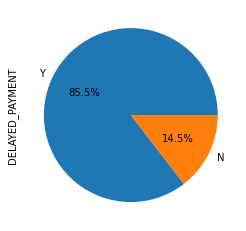

In [1153]:
customer_df.DELAYED_PAYMENT.value_counts(normalize= True).plot.pie(autopct='%1.1f%%')
plt.show()

### 14% of the customers are predicted to pay on time on all transactions

### 86% of the customers are likely to delay on atleast one of their payments

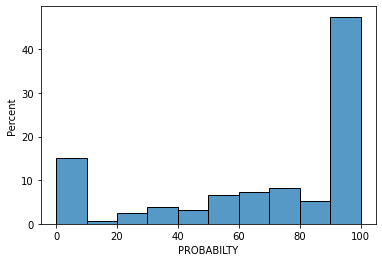

In [1154]:
sns.histplot(customer_df['PROBABILTY'],bins=10, stat='percent')
plt.show()

### 50% of the customers are likely to default on ~100% of their invoices

<AxesSubplot:xlabel='PROBABILTY', ylabel='Proportion'>

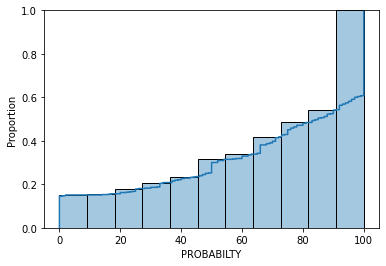

In [1155]:
sns.histplot(customer_df['PROBABILTY'], stat="proportion", cumulative=True, alpha=.4)
sns.ecdfplot(customer_df['PROBABILTY'], stat="proportion")

### 70% of the customers default on more than 50% of the invoices

In [1156]:
segment_df = pd.merge(customer_df, cust_segment_df[['CUSTOMER_NUMBER', 'SEGMENT_ID']], on='CUSTOMER_NUMBER')

In [1157]:
## Aggregating based on Segment ID

In [1158]:
segment_df.shape

(543, 5)

In [1159]:
cust_segment_df.shape

(1048, 4)

In [1160]:
segment_df.head()

,CUSTOMER_NUMBER,PREDICTION,PROBABILTY,DELAYED_PAYMENT,SEGMENT_ID
0,10360,0.000000,0,N,0
1,1044,0.712297,71,Y,4
2,1076,0.875000,87,Y,0
3,1146,0.500000,50,Y,4
4,1154,0.932203,93,Y,1


In [1161]:
segment_df.SEGMENT_ID.value_counts()

0    370
1    127
4     37
2      5
3      4
Name: SEGMENT_ID, dtype: int64

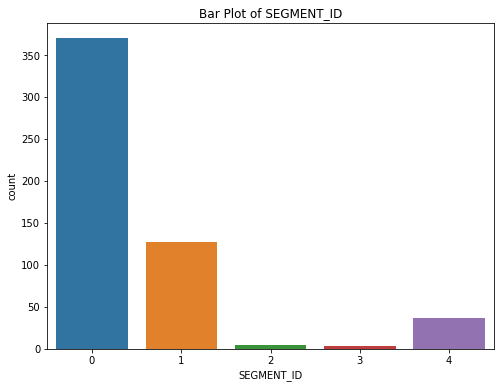

In [1162]:
univariate_count(segment_df,'SEGMENT_ID')

### Customers with open invoice mostly fall in Segments 0 and 1

##### <font color=red>*Note: Segment IDs may vary from the above when K-Means clustering is re-run</font>

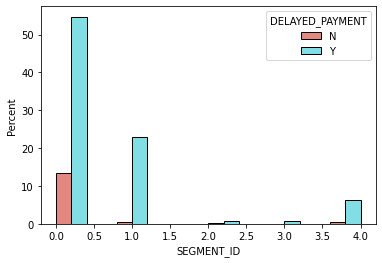

In [1164]:
sns.histplot(data=segment_df, x='SEGMENT_ID', bins=10, stat='percent', multiple='dodge',hue='DELAYED_PAYMENT',palette='hls')
plt.show()

### Most of the good customers among the open invoices are from Segment-0